#### Proximity analysis code 
(include title as an optional argument for the plot)

In [1]:
%%writefile /data/reddylab/projects/reddylab_utils/scripts/plot_cdf_distance_queries_to_target_bed_v1.py
#!/usr/bin/env python
import matplotlib
matplotlib.use('Agg')

import numpy as np
from pybedtools import BedTool
import pybedtools
from scipy.stats import mannwhitneyu
from statsmodels.distributions.empirical_distribution import ECDF
from reddylab_utils.reddylab_plotting_utils import discrete_cmap

font = {'size' : 8}
matplotlib.rc('font', **font)
import matplotlib.pyplot as plt

from matplotlib.patches import Polygon
import matplotlib.patches as mpatches
import palettable.colorbrewer.sequential

import argparse
parser = argparse.ArgumentParser(formatter_class=argparse.RawTextHelpFormatter, \
description="""

plot_cdf_distance_queries_to_target_bed_v1.py

This script plots the cumulative distribution function (CDF) of the distances
of all sites in each of a list of query bed files to a target bed file.
The script is same as that of plot_cdf_distance_queries_to_target_bed.py script, 
except for the addition of a new argument to add title for the CDF distance plot.

""")

##################################################
# required args:

parser.add_argument("--queries", nargs='+', type=str,
                    help="""required, file paths to beds of query sites of interest, e.g.:
/path/to/site_group1.bed /path/to/site_group2.bed etc.
""", dest="queries", required=True)

parser.add_argument("--names", nargs='+', type=str,
                    help="""required, list of names corresponding to query bed files, e.g.:
"Group 1" "Group 2" etc.

""", required=True)

parser.add_argument("--target", type=str,
                    help="""required, file path to bed of target sites:
""", required=True)

parser.add_argument("-o", '--outplot', dest='outplot', type=str,
                    help='required, outplot', required=True)

##################################################
# optional args:

parser.add_argument("--min_log_dist", type=float, default=0.,
                    help="min_log_dist", dest="min_log_dist")
parser.add_argument("--max_log_dist", type=float, default=6.,
                    help="max_log_dist", dest="max_log_dist")

parser.add_argument("--min_y", type=float, default=0.,
                    help="min_y", dest="min_y")
parser.add_argument("--max_y", type=float, default=1.,
                    help="max_y", dest="max_y")

parser.add_argument("--line_width", type=int, default=2,
                    help="line_width", dest="line_width")

parser.add_argument("--target_name", type=str,
                    default="target site", help="target_name", dest="target_name")
parser.add_argument("--colors", nargs="+")
parser.add_argument("--cmap", default="rainbow", 
                    help="""optional, name of matplotlib colormap, see:
                    http://matplotlib.org/examples/color/colormaps_reference.html
                    (default: %(default)s)""")
parser.add_argument("--title", type=str, 
                    default="target and queries", help="title", dest="title")
parser.add_argument("--fig_size_x", type=float,
                    default=3, help="fig_size_x", dest="fig_size_x")
parser.add_argument("--fig_size_y", type=float,
                    default=2, help="fig_size_y", dest="fig_size_y")
parser.add_argument("--ignore_overlapping",
                    help="""if you would like to ignore sites that are overlapping between
query and target, then indicate with flag. (Basically, rather than the closest site if
a given site has zero distance, the next closest site will be found with non-zero distance.)

""", dest="ignore_overlapping", action='store_true', default=False)

###################################################

args = parser.parse_args()

###################################################

tableau20 = [(31/255., 119/255., 180/255.), 
             (174/255., 199/255., 232/255.),
             (255/255., 127/255., 14/255.),
             (255/255., 187/255., 120/255.),    
             (44/255., 160/255., 44/255.),
             (152/255., 223/255., 138/255.),
             (214/255., 39/255., 40/255.),
             (255/255., 152/255., 150/255.),    
             (148/255., 103/255., 189/255.),
             (197/255., 176/255., 213/255.),
             (140/255., 86/255., 75/255.),
             (196/255., 156/255., 148/255.),    
             (227/255., 119/255., 194/255.),
             (247/255., 182/255., 210/255.),
             (127/255., 127/255., 127/255.),
             (199/255., 199/255., 199/255.),    
             (188/255., 189/255., 34/255.),
             (219/255., 219/255., 141/255.),
             (23/255., 190/255., 207/255.),
             (158/255., 218/255., 229/255.)]    
tableau10 = tableau20[::2]

if not args.colors:
    if args.cmap == "tableau":
        if len(args.queries) <= 10:
            colors = tableau10[:len(args.queries)+1]
        else:
            colors = tableau20
    else:
        colors = discrete_cmap(len(args.queries), args.cmap)
else:
    colors = args.colors

##########
# Get distance distribution and ECDF
##########

def extract_dist_from_BedTool(bed):
    dists = np.array([int(dist.split("\t")[-1]) for dist in str(bed).split('\n') if dist != ''])
    return(dists)

dx = 0.01
min_log_dist = args.min_log_dist
max_log_dist = args.max_log_dist

def find_ecdf_and_supporting(query, target, io):
    
    dists = extract_dist_from_BedTool(query.closest(target, io=io, d=True))
    dists[dists == -1] = 999999999
    
    median = np.median(dists)    
    ecdf = ECDF(np.log10(dists + 1))        
    
    results_dict = {'dists':dists, \
                    'median':median, \
                    'ecdf':ecdf}
    
    return(results_dict)

results_dict = {}
for name, query in zip(args.names, args.queries):
    results_dict[name] = find_ecdf_and_supporting(BedTool(query).sort(), BedTool(args.target).sort(), args.ignore_overlapping)

x = np.arange(int(np.floor(min_log_dist)), int(np.ceil(max_log_dist)), dx)

##########
# Plot
##########


def create_ecdf_plot(ax, ecdf, label, color):
    
    ax.plot(x, ecdf(x), color=color, lw=args.line_width, label=label)
    ax.axhline(0.5, color='gray', ls='--')
    ax.set_yticks([args.min_y,(args.min_y+args.max_y)/2,args.max_y])
    ax.set_xticks(np.arange(min_log_dist, max_log_dist+1))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.legend(loc='upper left', fontsize=8, frameon=False)

fig, ax = plt.subplots(figsize=(args.fig_size_x,args.fig_size_y))

for name, color in zip(args.names, colors):
    create_ecdf_plot(ax, results_dict[name]['ecdf'], label=name, color=color)

lgd = ax.legend(loc="upper left", frameon=False, fontsize=8)
# plt.gca().add_artist(lgd)
ax.set_ylabel('Cumulative probability', fontsize=8)
ax.set_xlabel('Log10 dist. to nearest %s'%(args.target_name), fontsize=8)
ax.set_ylim((args.min_y+-0.01,args.max_y+0.01))
ax.set_xlim((args.min_log_dist, args.max_log_dist*1.01))
ax.yaxis.set_tick_params(width=args.line_width)
ax.spines['left'].set_linewidth(args.line_width)
ax.xaxis.set_tick_params(width=args.line_width)
ax.spines['bottom'].set_linewidth(args.line_width)
ax.set_title('CDF distance plot between %s and query sites'%(args.title), fontsize=9)
plt.tight_layout()
plt.savefig(args.outplot)

##########
# Print median distance and Mann-Whitney U-test pairwise comparisons
##########

for name in args.names:
    print "Median distance %s to nearest target site = %s Kb"%(name, float(results_dict[name]['median'])/1000)

for i in range(len(args.names)):
    name1 = args.names[i]    
    for j in range(i):
        name2 = args.names[j]
        _,p = mannwhitneyu(results_dict[name1]['dists'], results_dict[name2]['dists'])
        print "Mann-whitney U-test, %s vs. %s, distance to nearest target site, p = %0.3e"%(name1, name2, p)
    


Overwriting /data/reddylab/projects/reddylab_utils/scripts/plot_cdf_distance_queries_to_target_bed_v1.py


##### Aggregate upregulated and downregulated genes from RNAseq DE genes list 

In [4]:
%%bash
fdr=0.05
file=Th17.Sorted.72hr_vs_mmTh0.Sorted.72hr
cd /data/reddylab/Revathy/dev/rna-seq_Siklenka/results/rna_seq/differential_testing/deseq2/timeseries
####upreg genes
tail -n+2 ${file}.txt |  awk -vFDR=${fdr} '{if(($NF<FDR) && ($3>0)){print $1}}' > ${file}.up_genes.txt
####downreg genes
tail -n+2 ${file}.txt |  awk -vFDR=${fdr} '{if(($NF<FDR) && ($3<0)){print $1}}' > ${file}.down_genes.txt


##### Proximity analysis comparing atacseq increase, decrease with rnaseq downregulated genes

In [11]:
import pandas as pd

downreg_file = pd.read_csv('/data/reddylab/Revathy/dev/rna-seq_Siklenka/results/rna_seq/differential_testing/deseq2/timeseries/Th17.Sorted.72hr_vs_mmTh0.Sorted.72hr.down_genes.txt', sep = '\t', header=None)
downreg_file.columns = ['Unnamed: 0']
bed_file = pd.read_csv('/data/reddylab/Reference_Data/Gencode/vM19/gencode.vM19.basic.annotation.no_gm.bed', sep = '\t', header = None)
bed_file.columns = ['Chr', 'Start', 'End', 'Unnamed: 0', '4', 'Spec', 'GeneName', 'GeneFunc']

downreg_data = downreg_file.merge(bed_file, on='Unnamed: 0')
downreg_protein_coding = downreg_data[downreg_data['GeneFunc'] == 'protein_coding']
downreg_protein_coding.drop(columns = ['Unnamed: 0','GeneName','4','Spec','GeneFunc'], inplace=True)
downreg_protein_coding.to_csv('/data/reddylab/Revathy/dev/rna-seq_Siklenka/results/rna_seq/differential_testing/deseq2/timeseries/Th17.Sorted.72hr_vs_mmTh0.Sorted.72hr.down_protein_coding_genes.bed',index=False, header=False, sep='\t')


In [12]:
%%bash
wc -l /data/reddylab/Revathy/dev/rna-seq_Siklenka/results/rna_seq/differential_testing/deseq2/timeseries/Th17.Sorted.72hr_vs_mmTh0.Sorted.72hr.down_protein_coding_genes.bed

3330 /data/reddylab/Revathy/dev/rna-seq_Siklenka/results/rna_seq/differential_testing/deseq2/timeseries/Th17.Sorted.72hr_vs_mmTh0.Sorted.72hr.down_protein_coding_genes.bed


In [14]:
%%bash
module load gcc
export PYTHONPATH='/data/reddylab/projects/reddylab_utils/'
source /data/reddylab/software/miniconda2/bin/activate alex
python /data/reddylab/projects/reddylab_utils/scripts/plot_cdf_distance_queries_to_target_bed.py \
--queries /data/reddylab/Alex/collab/20190105_Keith/results/atac_seq/deseq2/Th17.atacseq.activated_sorted.072h_vs_Th0.atacseq.activated_sorted.072h.increase.bed /data/reddylab/Alex/collab/20190105_Keith/results/atac_seq/deseq2/Th17.atacseq.activated_sorted.072h_vs_Th0.atacseq.activated_sorted.072h.decrease.bed \
--names "increase" "decrease" \
--target /data/reddylab/Revathy/dev/rna-seq_Siklenka/results/rna_seq/differential_testing/deseq2/timeseries/Th17.Sorted.72hr_vs_mmTh0.Sorted.72hr.down_genes.bed \
-o /data/reddylab/Revathy/dev/rna-seq_Siklenka/results/rna_seq/integration/rna_atac/Th17_inc_dec_downreg.png \
--min_log_dist 3 \
--max_log_dist 8 \
--fig_size_x 8 \
--fig_size_y 5 \

Median distance increase to nearest target site = 308.436 Kb
Median distance decrease to nearest target site = 63.526 Kb
Mann-whitney U-test, decrease vs. increase, distance to nearest target site, p = 0.000e+00


In [2]:
!head /data/reddylab/Revathy/collabs/rna-seq_Siklenka/results/rna_seq/differential_testing/deseq2/timeseries/Th17.Sorted.72hr_vs_mmTh0.Sorted.72hr.down_genes.bed

chr1	171917514	171953170
chr4	4133530	4138477
chr6	145121738	145174934
chr11	70657201	70662513
chr12	113418557	113422730
chr18	60803847	60812646
chr19	11443572	11463549
chrX	107397098	107403376
chr9	14353989	14381242
chr11	99144195	99155077


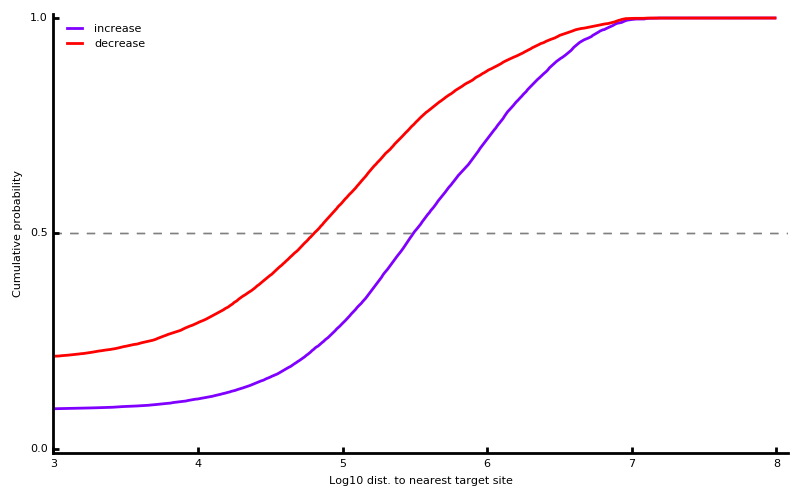

In [15]:
from IPython.display import display,Image

display(Image('/data/reddylab/Revathy/dev/rna-seq_Siklenka/results/rna_seq/integration/rna_atac/Th17_inc_dec_downreg.png'))


##### Proximity analysis comparing sig_da peaks, non_sig_da peaks from atacseq to the DE genes from rnaseq

In [ ]:
import pandas as pd

acc_peaks = pd.read_csv('/data/reddylab/Alex/collab/20190105_Keith/results/atac_seq/deseq2/Th17.atacseq.activated_sorted.072h_vs_Th0.atacseq.activated_sorted.072h.accessible_peaks.txt', header=None)
acc_peaks.columns = ['locus']
da_peaks = pd.read_csv('/data/reddylab/Alex/collab/20190105_Keith/results/atac_seq/deseq2/Th17.atacseq.activated_sorted.072h_vs_Th0.atacseq.activated_sorted.072h.sig_da.bed', sep='\t', header=None)
da_peaks.columns = ['chr','start','end','locus','value','none']

non_da_peak_list = [e for e in list(acc_peaks['locus']) if e not in list(da_peaks['locus'])]
non_da_peaks = pd.DataFrame(non_da_peak_list, columns = ['locus'])
non_da_peaks['chr'], non_da_peaks['start'], non_da_peaks['end'] = non_da_peaks['locus'].str.split('_', 2).str
non_da_peaks.drop(columns = ['locus'], inplace=True)

da_peaks.drop(columns = ['locus','value','none'], inplace=True)

da_peaks.to_csv('/data/reddylab/Revathy/dev/rna-seq_Siklenka/results/rna_seq/integration/rna_atac/Th17.atacseq.activated_sorted.072h_vs_Th0.atacseq.activated_sorted.072h.sig_da.bed', sep='\t', index=False, header=False)
non_da_peaks.to_csv('/data/reddylab/Revathy/dev/rna-seq_Siklenka/results/rna_seq/integration/rna_atac/Th17.atacseq.activated_sorted.072h_vs_Th0.atacseq.activated_sorted.072h.non_sig_da.bed', sep='\t', index=False, header=False)


In [7]:
!wc -l /data/reddylab/Revathy/dev/rna-seq_Siklenka/results/rna_seq/integration/rna_atac/Th17.atacseq.activated_sorted.072h_vs_Th0.atacseq.activated_sorted.072h.sig_da.bed

46484 /data/reddylab/Revathy/dev/rna-seq_Siklenka/results/rna_seq/integration/rna_atac/Th17.atacseq.activated_sorted.072h_vs_Th0.atacseq.activated_sorted.072h.sig_da.bed


In [9]:
%%bash
cd /data/reddylab/Revathy/dev/rna-seq_Siklenka/results/rna_seq/integration/rna_atac
wc -l Th17.atacseq.activated_sorted.072h_vs_Th0.atacseq.activated_sorted.072h.non_sig_da.bed



56823 Th17.atacseq.activated_sorted.072h_vs_Th0.atacseq.activated_sorted.072h.non_sig_da.bed


In [12]:
%%bash
cd /data/reddylab/Revathy/dev/rna-seq_Siklenka/results/rna_seq/integration/rna_atac
file=Th17.atacseq.activated_sorted.072h_vs_Th0.atacseq.activated_sorted.072h.non_sig_da
cat ${file}.bed | shuf ${file}.bed | head -n 24000 > ${file}.shuf_24000.bed 

In [11]:
%%bash 

wc -l  /data/reddylab/Revathy/dev/rna-seq_Siklenka/results/rna_seq/integration/rna_atac/Th17.atacseq.activated_sorted.072h_vs_Th0.atacseq.activated_sorted.072h.non_sig_da.shuf_45000.bed /data/reddylab/Alex/collab/20190105_Keith/results/atac_seq/deseq2/Th17.atacseq.activated_sorted.072h_vs_Th0.atacseq.activated_sorted.072h.increase.bed /data/reddylab/Alex/collab/20190105_Keith/results/atac_seq/deseq2/Th17.atacseq.activated_sorted.072h_vs_Th0.atacseq.activated_sorted.072h.decrease.bed


  45000 /data/reddylab/Revathy/dev/rna-seq_Siklenka/results/rna_seq/integration/rna_atac/Th17.atacseq.activated_sorted.072h_vs_Th0.atacseq.activated_sorted.072h.non_sig_da.shuf_45000.bed
  23668 /data/reddylab/Alex/collab/20190105_Keith/results/atac_seq/deseq2/Th17.atacseq.activated_sorted.072h_vs_Th0.atacseq.activated_sorted.072h.increase.bed
  22814 /data/reddylab/Alex/collab/20190105_Keith/results/atac_seq/deseq2/Th17.atacseq.activated_sorted.072h_vs_Th0.atacseq.activated_sorted.072h.decrease.bed
  91482 total


In [17]:
%%bash
wc -l /data/reddylab/Revathy/dev/rna-seq_Siklenka/results/rna_seq/differential_testing/deseq2/timeseries/Th17.Sorted.72hr_vs_mmTh0.Sorted.72hr.with_bed_coordinates.bed /data/reddylab/Revathy/dev/rna-seq_Siklenka/results/rna_seq/differential_testing/deseq2/timeseries/Th17.Sorted.72hr_vs_mmTh0.Sorted.72hr.down_genes.bed /data/reddylab/Revathy/dev/rna-seq_Siklenka/results/rna_seq/differential_testing/deseq2/timeseries/Th17.Sorted.72hr_vs_mmTh0.Sorted.72hr.up_genes.bed


 10692 /data/reddylab/Revathy/dev/rna-seq_Siklenka/results/rna_seq/differential_testing/deseq2/timeseries/Th17.Sorted.72hr_vs_mmTh0.Sorted.72hr.with_bed_coordinates.bed
  3504 /data/reddylab/Revathy/dev/rna-seq_Siklenka/results/rna_seq/differential_testing/deseq2/timeseries/Th17.Sorted.72hr_vs_mmTh0.Sorted.72hr.down_genes.bed
  3508 /data/reddylab/Revathy/dev/rna-seq_Siklenka/results/rna_seq/differential_testing/deseq2/timeseries/Th17.Sorted.72hr_vs_mmTh0.Sorted.72hr.up_genes.bed
 17704 total


##### Proximity analysis for Non-sig., Increasing and Decreasing DA peaks with all DE genes as targets

In [13]:
%%bash
module load gcc
export PYTHONPATH='/data/reddylab/projects/reddylab_utils/'
source /data/reddylab/software/miniconda2/bin/activate alex
python /data/reddylab/projects/reddylab_utils/scripts/plot_cdf_distance_queries_to_target_bed_v1.py \
--queries /data/reddylab/Revathy/dev/rna-seq_Siklenka/results/rna_seq/integration/rna_atac/Th17.atacseq.activated_sorted.072h_vs_Th0.atacseq.activated_sorted.072h.non_sig_da.shuf_24000.bed /data/reddylab/Alex/collab/20190105_Keith/results/atac_seq/deseq2/Th17.atacseq.activated_sorted.072h_vs_Th0.atacseq.activated_sorted.072h.increase.bed /data/reddylab/Alex/collab/20190105_Keith/results/atac_seq/deseq2/Th17.atacseq.activated_sorted.072h_vs_Th0.atacseq.activated_sorted.072h.decrease.bed \
--names "non_sig_da" "increase" "decrease" \
--target /data/reddylab/Revathy/dev/rna-seq_Siklenka/results/rna_seq/differential_testing/deseq2/timeseries/Th17.Sorted.72hr_vs_mmTh0.Sorted.72hr.with_bed_coordinates.bed \
-o /data/reddylab/Revathy/dev/rna-seq_Siklenka/results/rna_seq/integration/rna_atac/Th17_nonsigda_inc_dec_24000.png \
--min_log_dist 3 \
--max_log_dist 7 \
--target_name "DE genes" \
--title "10692 target DE genes" \
--fig_size_x 8 \
--fig_size_y 5 \

Process is terminated.


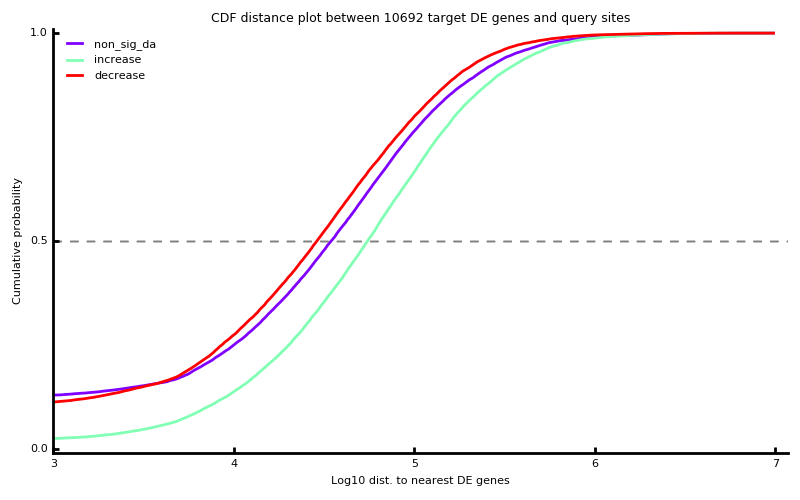

In [12]:
from IPython.display import display,Image

display(Image('/data/reddylab/Revathy/dev/rna-seq_Siklenka/results/rna_seq/integration/rna_atac/Th17_nonsigda_inc_dec_24000.png'))


##### Proximity analysis for Non-sig., Increasing and Decreasing DA peaks with all upregulated genes as targets

In [2]:
%%bash
module load gcc
export PYTHONPATH='/data/reddylab/projects/reddylab_utils/'
source /data/reddylab/software/miniconda2/bin/activate alex
python /data/reddylab/projects/reddylab_utils/scripts/plot_cdf_distance_queries_to_target_bed_v1.py \
--queries /data/reddylab/Revathy/dev/rna-seq_Siklenka/results/rna_seq/integration/rna_atac/Th17.atacseq.activated_sorted.072h_vs_Th0.atacseq.activated_sorted.072h.non_sig_da.shuf_45000.bed /data/reddylab/Alex/collab/20190105_Keith/results/atac_seq/deseq2/Th17.atacseq.activated_sorted.072h_vs_Th0.atacseq.activated_sorted.072h.increase.bed /data/reddylab/Alex/collab/20190105_Keith/results/atac_seq/deseq2/Th17.atacseq.activated_sorted.072h_vs_Th0.atacseq.activated_sorted.072h.decrease.bed \
--names "non_sig_da" "increase" "decrease" \
--target /data/reddylab/Revathy/dev/rna-seq_Siklenka/results/rna_seq/differential_testing/deseq2/timeseries/Th17.Sorted.72hr_vs_mmTh0.Sorted.72hr.up_genes.bed \
-o /data/reddylab/Revathy/dev/rna-seq_Siklenka/results/rna_seq/integration/rna_atac/Th17_sigda_nonsigda_inc_dec_upreg.png \
--min_log_dist 3 \
--max_log_dist 7 \
--target_name "Upregulated genes" \
--title "3508 upreg DE genes" \
--fig_size_x 8 \
--fig_size_y 5 \

Median distance non_sig_da to nearest target site = 103.5 Kb
Median distance increase to nearest target site = 122.0175 Kb
Median distance decrease to nearest target site = 113.316 Kb
Mann-whitney U-test, increase vs. non_sig_da, distance to nearest target site, p = 6.957e-11
Mann-whitney U-test, decrease vs. non_sig_da, distance to nearest target site, p = 6.090e-17
Mann-whitney U-test, decrease vs. increase, distance to nearest target site, p = 3.026e-01


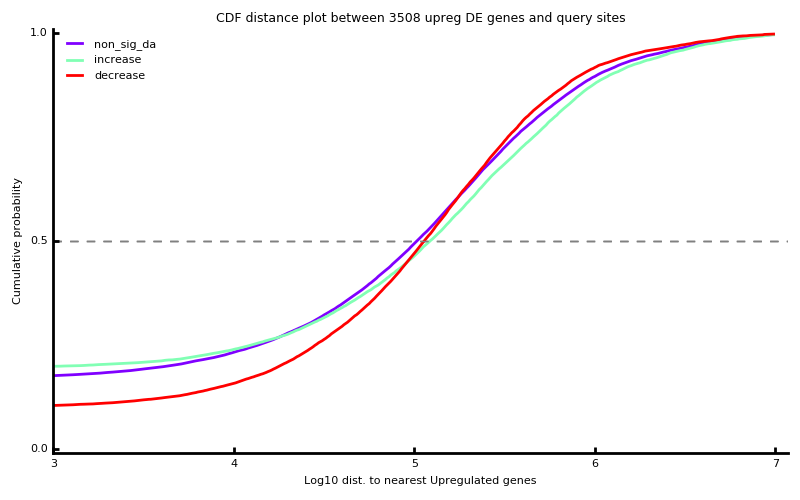

In [3]:
from IPython.display import display,Image

display(Image('/data/reddylab/Revathy/dev/rna-seq_Siklenka/results/rna_seq/integration/rna_atac/Th17_sigda_nonsigda_inc_dec_upreg.png'))


##### Proximity analysis for Non-sig., Increasing and Decreasing DA peaks with downregulated DE genes as targets

In [5]:
%%bash
module load gcc
export PYTHONPATH='/data/reddylab/projects/reddylab_utils/'
source /data/reddylab/software/miniconda2/bin/activate alex
python /data/reddylab/projects/reddylab_utils/scripts/plot_cdf_distance_queries_to_target_bed_v1.py \
--queries /data/reddylab/Revathy/dev/rna-seq_Siklenka/results/rna_seq/integration/rna_atac/Th17.atacseq.activated_sorted.072h_vs_Th0.atacseq.activated_sorted.072h.non_sig_da.shuf_45000.bed /data/reddylab/Alex/collab/20190105_Keith/results/atac_seq/deseq2/Th17.atacseq.activated_sorted.072h_vs_Th0.atacseq.activated_sorted.072h.increase.bed /data/reddylab/Alex/collab/20190105_Keith/results/atac_seq/deseq2/Th17.atacseq.activated_sorted.072h_vs_Th0.atacseq.activated_sorted.072h.decrease.bed \
--names "non_sig_da" "increase" "decrease" \
--target /data/reddylab/Revathy/dev/rna-seq_Siklenka/results/rna_seq/differential_testing/deseq2/timeseries/Th17.Sorted.72hr_vs_mmTh0.Sorted.72hr.down_genes.bed \
-o /data/reddylab/Revathy/dev/rna-seq_Siklenka/results/rna_seq/integration/rna_atac/Th17_nonsigda_inc_dec_downreg.png \
--min_log_dist 3 \
--max_log_dist 7 \
--target_name "Down-regulated genes" \
--title "3504 down-reg DE genes" \
--fig_size_x 8 \
--fig_size_y 5 \

Median distance non_sig_da to nearest target site = 157.98 Kb
Median distance increase to nearest target site = 308.436 Kb
Median distance decrease to nearest target site = 63.526 Kb
Mann-whitney U-test, increase vs. non_sig_da, distance to nearest target site, p = 1.595e-287
Mann-whitney U-test, decrease vs. non_sig_da, distance to nearest target site, p = 0.000e+00
Mann-whitney U-test, decrease vs. increase, distance to nearest target site, p = 0.000e+00


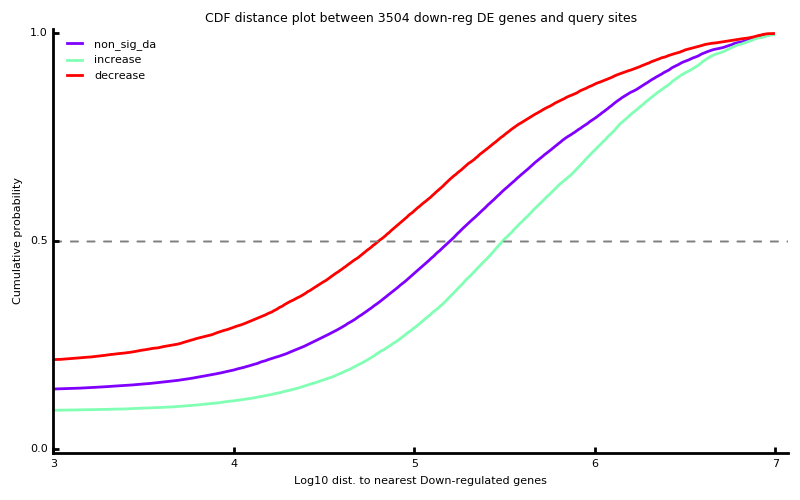

In [6]:
from IPython.display import display,Image

display(Image('/data/reddylab/Revathy/dev/rna-seq_Siklenka/results/rna_seq/integration/rna_atac/Th17_nonsigda_inc_dec_downreg.png'))


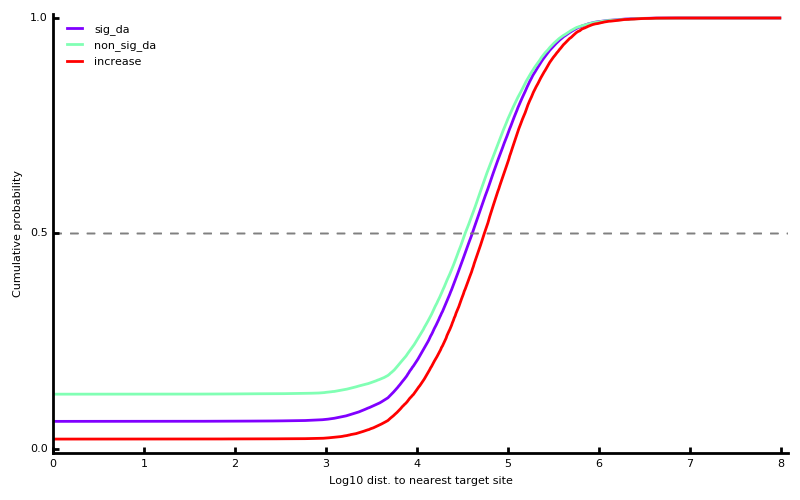

In [7]:
from IPython.display import display,Image

display(Image('/data/reddylab/Revathy/dev/rna-seq_Siklenka/results/rna_seq/integration/rna_atac/Th17_sigda_nonsigda_shuf.png'))


#### Proximity analysis with protein coding target DE genes

In [20]:
import pandas as pd

de_genes = pd.read_csv('/data/reddylab/Revathy/dev/rna-seq_Siklenka/results/rna_seq/differential_testing/deseq2/timeseries/Th17.Sorted.72hr_vs_mmTh0.Sorted.72hr.with_genes.txt', sep='\t')
de_genes_protein_coding = de_genes[de_genes['GeneType'] == 'protein_coding']
de_genes_protein_coding.drop(columns = ['baseMean','log2FoldChange','lfcSE','pvalue','padj','GeneName','GeneType'], inplace=True)

bed_file = pd.read_csv('/data/reddylab/Reference_Data/Gencode/vM19/gencode.vM19.basic.annotation.no_gm.bed', sep = '\t', header = None)
bed_file.columns = ['Chr', 'Start', 'End', 'Unnamed: 0', '4', 'Spec', 'GeneName', 'GeneType']

de_gene_data = de_genes_protein_coding.merge(bed_file, on='Unnamed: 0')

de_gene_data.drop(columns = ['Unnamed: 0','GeneName','4','Spec','GeneType'], inplace=True)
de_gene_data.to_csv('/data/reddylab/Revathy/dev/rna-seq_Siklenka/results/rna_seq/differential_testing/deseq2/timeseries/Th17.Sorted.72hr_vs_mmTh0.Sorted.72hr.with_protein_coding_genes.bed',index=False, header=False, sep='\t')



In [21]:
%%bash

wc -l /data/reddylab/Revathy/dev/rna-seq_Siklenka/results/rna_seq/differential_testing/deseq2/timeseries/Th17.Sorted.72hr_vs_mmTh0.Sorted.72hr.with_protein_coding_genes.bed

9053 /data/reddylab/Revathy/dev/rna-seq_Siklenka/results/rna_seq/differential_testing/deseq2/timeseries/Th17.Sorted.72hr_vs_mmTh0.Sorted.72hr.with_protein_coding_genes.bed


In [27]:
%%bash
module load gcc
export PYTHONPATH='/data/reddylab/projects/reddylab_utils/'
source /data/reddylab/software/miniconda2/bin/activate alex
python /data/reddylab/projects/reddylab_utils/scripts/plot_cdf_distance_queries_to_target_bed_v1.py \
--queries /data/reddylab/Revathy/dev/rna-seq_Siklenka/results/rna_seq/integration/rna_atac/Th17.atacseq.activated_sorted.072h_vs_Th0.atacseq.activated_sorted.072h.non_sig_da.shuf_24000.bed /data/reddylab/Alex/collab/20190105_Keith/results/atac_seq/deseq2/Th17.atacseq.activated_sorted.072h_vs_Th0.atacseq.activated_sorted.072h.increase.bed /data/reddylab/Alex/collab/20190105_Keith/results/atac_seq/deseq2/Th17.atacseq.activated_sorted.072h_vs_Th0.atacseq.activated_sorted.072h.decrease.bed \
--names "non_sig_da" "increase" "decrease" \
--target /data/reddylab/Revathy/dev/rna-seq_Siklenka/results/rna_seq/differential_testing/deseq2/timeseries/Th17.Sorted.72hr_vs_mmTh0.Sorted.72hr.with_protein_coding_genes.bed \
-o /data/reddylab/Revathy/dev/rna-seq_Siklenka/results/rna_seq/integration/rna_atac/Th17_nonsigda_inc_dec_24000_protein_coding.png \
--min_log_dist 2 \
--max_log_dist 7 \
--target_name "DE genes" \
--title "9053 target protein_coding DE genes" \
--fig_size_x 8 \
--fig_size_y 5 \

Median distance non_sig_da to nearest target site = 10.5115 Kb
Median distance increase to nearest target site = 22.6465 Kb
Median distance decrease to nearest target site = 10.3655 Kb
Mann-whitney U-test, increase vs. non_sig_da, distance to nearest target site, p = 6.014e-48
Mann-whitney U-test, decrease vs. non_sig_da, distance to nearest target site, p = 5.318e-02
Mann-whitney U-test, decrease vs. increase, distance to nearest target site, p = 3.076e-63


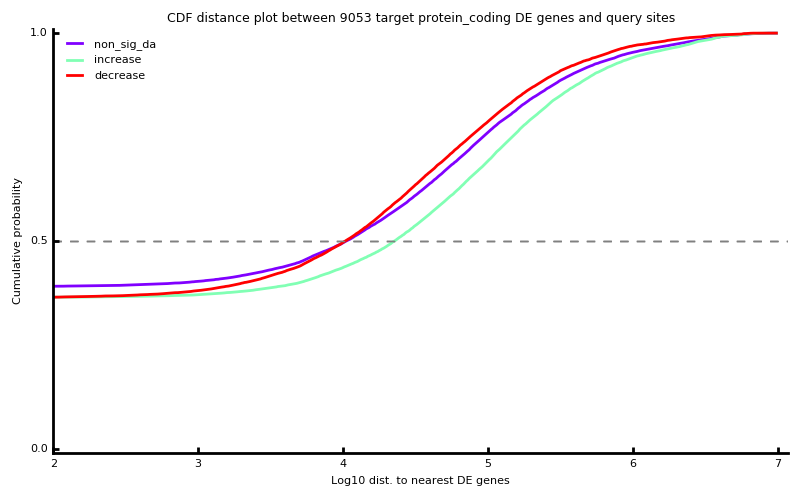

In [28]:
from IPython.display import display,Image

display(Image('/data/reddylab/Revathy/dev/rna-seq_Siklenka/results/rna_seq/integration/rna_atac/Th17_nonsigda_inc_dec_24000_protein_coding.png'))


Downreg. and Upreg. protein coding DE genes

In [30]:
import pandas as pd

downreg_file = pd.read_csv('/data/reddylab/Revathy/dev/rna-seq_Siklenka/results/rna_seq/differential_testing/deseq2/timeseries/Th17.Sorted.72hr_vs_mmTh0.Sorted.72hr.down_genes.txt', sep = '\t', header=None)
downreg_file.columns = ['Unnamed: 0']
bed_file = pd.read_csv('/data/reddylab/Reference_Data/Gencode/vM19/gencode.vM19.basic.annotation.no_gm.bed', sep = '\t', header = None)
bed_file.columns = ['Chr', 'Start', 'End', 'Unnamed: 0', '4', 'Spec', 'GeneName', 'GeneFunc']

downreg_data = downreg_file.merge(bed_file, on='Unnamed: 0')
downreg_protein_coding = downreg_data[downreg_data['GeneFunc'] == 'protein_coding']
downreg_protein_coding.drop(columns = ['Unnamed: 0','GeneName','4','Spec','GeneFunc'], inplace=True)
downreg_protein_coding.to_csv('/data/reddylab/Revathy/dev/rna-seq_Siklenka/results/rna_seq/differential_testing/deseq2/timeseries/Th17.Sorted.72hr_vs_mmTh0.Sorted.72hr.down_protein_coding_genes.bed',index=False, header=False, sep='\t')

upreg_file = pd.read_csv('/data/reddylab/Revathy/dev/rna-seq_Siklenka/results/rna_seq/differential_testing/deseq2/timeseries/Th17.Sorted.72hr_vs_mmTh0.Sorted.72hr.up_genes.txt', sep = '\t', header=None)
upreg_file.columns = ['Unnamed: 0']

upreg_data = upreg_file.merge(bed_file, on='Unnamed: 0')
upreg_protein_coding = upreg_data[upreg_data['GeneFunc'] == 'protein_coding']
upreg_protein_coding.drop(columns = ['Unnamed: 0','GeneName','4','Spec','GeneFunc'], inplace=True)
upreg_protein_coding.to_csv('/data/reddylab/Revathy/dev/rna-seq_Siklenka/results/rna_seq/differential_testing/deseq2/timeseries/Th17.Sorted.72hr_vs_mmTh0.Sorted.72hr.up_protein_coding_genes.bed',index=False, header=False, sep='\t')

In [33]:
%%bash

wc -l /data/reddylab/Revathy/dev/rna-seq_Siklenka/results/rna_seq/differential_testing/deseq2/timeseries/Th17.Sorted.72hr_vs_mmTh0.Sorted.72hr.up_protein_coding_genes.bed
wc -l /data/reddylab/Revathy/dev/rna-seq_Siklenka/results/rna_seq/differential_testing/deseq2/timeseries/Th17.Sorted.72hr_vs_mmTh0.Sorted.72hr.down_protein_coding_genes.bed

3469 /data/reddylab/Revathy/dev/rna-seq_Siklenka/results/rna_seq/differential_testing/deseq2/timeseries/Th17.Sorted.72hr_vs_mmTh0.Sorted.72hr.up_protein_coding_genes.bed
3330 /data/reddylab/Revathy/dev/rna-seq_Siklenka/results/rna_seq/differential_testing/deseq2/timeseries/Th17.Sorted.72hr_vs_mmTh0.Sorted.72hr.down_protein_coding_genes.bed


In [36]:
%%bash
module load gcc
export PYTHONPATH='/data/reddylab/projects/reddylab_utils/'
source /data/reddylab/software/miniconda2/bin/activate alex
python /data/reddylab/projects/reddylab_utils/scripts/plot_cdf_distance_queries_to_target_bed_v1.py \
--queries /data/reddylab/Revathy/dev/rna-seq_Siklenka/results/rna_seq/integration/rna_atac/Th17.atacseq.activated_sorted.072h_vs_Th0.atacseq.activated_sorted.072h.non_sig_da.shuf_45000.bed /data/reddylab/Alex/collab/20190105_Keith/results/atac_seq/deseq2/Th17.atacseq.activated_sorted.072h_vs_Th0.atacseq.activated_sorted.072h.increase.bed /data/reddylab/Alex/collab/20190105_Keith/results/atac_seq/deseq2/Th17.atacseq.activated_sorted.072h_vs_Th0.atacseq.activated_sorted.072h.decrease.bed \
--names "non_sig_da" "increase" "decrease" \
--target /data/reddylab/Revathy/dev/rna-seq_Siklenka/results/rna_seq/differential_testing/deseq2/timeseries/Th17.Sorted.72hr_vs_mmTh0.Sorted.72hr.up_protein_coding_genes.bed \
-o /data/reddylab/Revathy/dev/rna-seq_Siklenka/results/rna_seq/integration/rna_atac/Th17_nonsigda_inc_dec_upreg_protein.png \
--min_log_dist 3 \
--max_log_dist 7 \
--target_name "Upregulated genes" \
--title "3469 upreg DE genes" \
--fig_size_x 8 \
--fig_size_y 5 \

Median distance non_sig_da to nearest target site = 104.9835 Kb
Median distance increase to nearest target site = 124.784 Kb
Median distance decrease to nearest target site = 115.094 Kb
Mann-whitney U-test, increase vs. non_sig_da, distance to nearest target site, p = 8.707e-11
Mann-whitney U-test, decrease vs. non_sig_da, distance to nearest target site, p = 1.337e-17
Mann-whitney U-test, decrease vs. increase, distance to nearest target site, p = 2.430e-01


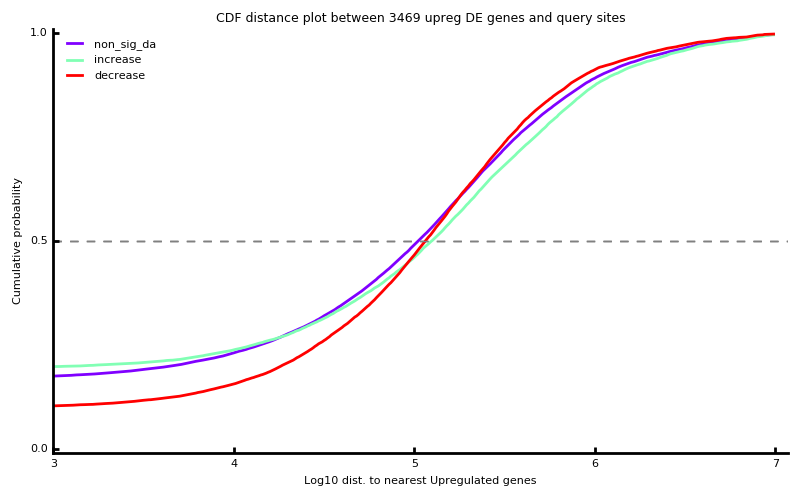

In [37]:
from IPython.display import display,Image

display(Image('/data/reddylab/Revathy/dev/rna-seq_Siklenka/results/rna_seq/integration/rna_atac/Th17_nonsigda_inc_dec_upreg_protein.png'))


In [38]:
%%bash
module load gcc
export PYTHONPATH='/data/reddylab/projects/reddylab_utils/'
source /data/reddylab/software/miniconda2/bin/activate alex
python /data/reddylab/projects/reddylab_utils/scripts/plot_cdf_distance_queries_to_target_bed_v1.py \
--queries /data/reddylab/Revathy/dev/rna-seq_Siklenka/results/rna_seq/integration/rna_atac/Th17.atacseq.activated_sorted.072h_vs_Th0.atacseq.activated_sorted.072h.non_sig_da.shuf_45000.bed /data/reddylab/Alex/collab/20190105_Keith/results/atac_seq/deseq2/Th17.atacseq.activated_sorted.072h_vs_Th0.atacseq.activated_sorted.072h.increase.bed /data/reddylab/Alex/collab/20190105_Keith/results/atac_seq/deseq2/Th17.atacseq.activated_sorted.072h_vs_Th0.atacseq.activated_sorted.072h.decrease.bed \
--names "non_sig_da" "increase" "decrease" \
--target /data/reddylab/Revathy/dev/rna-seq_Siklenka/results/rna_seq/differential_testing/deseq2/timeseries/Th17.Sorted.72hr_vs_mmTh0.Sorted.72hr.down_protein_coding_genes.bed \
-o /data/reddylab/Revathy/dev/rna-seq_Siklenka/results/rna_seq/integration/rna_atac/Th17_nonsigda_inc_dec_downreg_protein.png \
--min_log_dist 3 \
--max_log_dist 7 \
--target_name "Down-regulated genes" \
--title "3330 down-reg DE genes" \
--fig_size_x 8 \
--fig_size_y 5 \

Median distance non_sig_da to nearest target site = 171.095 Kb
Median distance increase to nearest target site = 329.515 Kb
Median distance decrease to nearest target site = 67.519 Kb
Mann-whitney U-test, increase vs. non_sig_da, distance to nearest target site, p = 3.339e-270
Mann-whitney U-test, decrease vs. non_sig_da, distance to nearest target site, p = 0.000e+00
Mann-whitney U-test, decrease vs. increase, distance to nearest target site, p = 0.000e+00


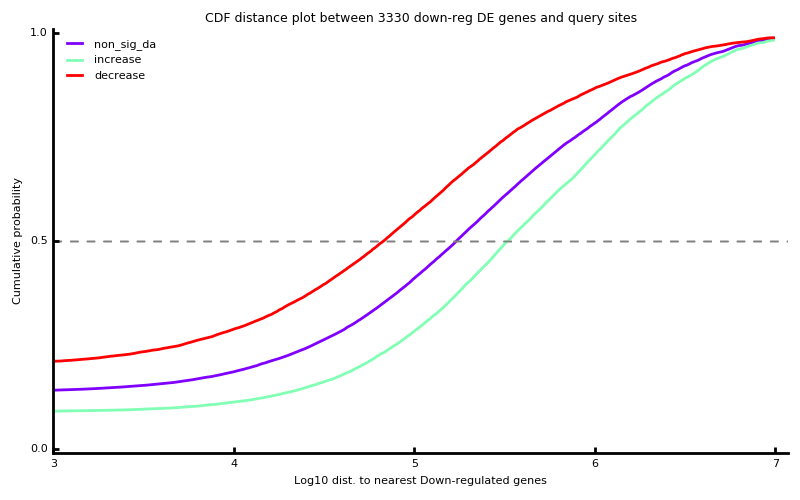

In [40]:
from IPython.display import display,Image

display(Image('/data/reddylab/Revathy/dev/rna-seq_Siklenka/results/rna_seq/integration/rna_atac/Th17_nonsigda_inc_dec_downreg_protein.png'))


### Proximity Analysis for ATACSTARseq data(2020)

In [7]:
%%bash 
mkdir -p /data/reddylab/Revathy/dev/atac-seq_Siklenka/results/proximity_analysis

In [3]:
import pandas as pd

acc_peaks = pd.read_csv('/data/reddylab/Revathy/dev/atac-seq_Siklenka/results/deseq2/Th17.72hrs.ASTARR.insert_vs_Th0.72hrs.ASTARR.insert.accessible_peaks.txt', header=None)
acc_peaks.columns = ['locus']
da_peaks = pd.read_csv('/data/reddylab/Revathy/dev/atac-seq_Siklenka/results/deseq2/Th17.72hrs.ASTARR.insert_vs_Th0.72hrs.ASTARR.insert.sig_da.bed', sep='\t', header=None)
da_peaks.columns = ['chr','start','end','locus','value','none']

non_da_peak_list = [e for e in list(acc_peaks['locus']) if e not in list(da_peaks['locus'])]
non_da_peaks = pd.DataFrame(non_da_peak_list, columns = ['locus'])
non_da_peaks['chr'], non_da_peaks['start'], non_da_peaks['end'] = non_da_peaks['locus'].str.split('_', 2).str
non_da_peaks.drop(columns = ['locus'], inplace=True)

da_peaks.drop(columns = ['locus','value','none'], inplace=True)

da_peaks.to_csv('/data/reddylab/Revathy/dev/atac-seq_Siklenka/c-seq_Siklenka/results/proximity_analysis/Th17.72hrs.ASTARR.insert_vs_Th0.72hrs.ASTARR.insert.sig_da.bed', sep='\t', index=False, header=False)
non_da_peaks.to_csv('/data/reddylab/Revathy/dev/atac-seq_Siklenka/results/proximity_analysis/Th17.72hrs.ASTARR.insert_vs_Th0.72hrs.ASTARR.insert.non_sig_da.bed', sep='\t', index=False, header=False)


In [11]:
%%bash 
wc -l /data/reddylab/Revathy/dev/atac-seq_Siklenka/results/proximity_analysis/Th17.72hrs.ASTARR.insert_vs_Th0.72hrs.ASTARR.insert.sig_da.bed
wc -l /data/reddylab/Revathy/dev/atac-seq_Siklenka/results/proximity_analysis/Th17.72hrs.ASTARR.insert_vs_Th0.72hrs.ASTARR.insert.non_sig_da.bed
wc -l /data/reddylab/Revathy/dev/atac-seq_Siklenka/results/deseq2/Th17.72hrs.ASTARR.insert_vs_Th0.72hrs.ASTARR.insert.increase.bed
wc -l /data/reddylab/Revathy/dev/atac-seq_Siklenka/results/deseq2/Th17.72hrs.ASTARR.insert_vs_Th0.72hrs.ASTARR.insert.decrease.bed


40127 /data/reddylab/Revathy/dev/atac-seq_Siklenka/results/proximity_analysis/Th17.72hrs.ASTARR.insert_vs_Th0.72hrs.ASTARR.insert.sig_da.bed
23659 /data/reddylab/Revathy/dev/atac-seq_Siklenka/results/proximity_analysis/Th17.72hrs.ASTARR.insert_vs_Th0.72hrs.ASTARR.insert.non_sig_da.bed
13761 /data/reddylab/Revathy/dev/atac-seq_Siklenka/results/deseq2/Th17.72hrs.ASTARR.insert_vs_Th0.72hrs.ASTARR.insert.increase.bed
26364 /data/reddylab/Revathy/dev/atac-seq_Siklenka/results/deseq2/Th17.72hrs.ASTARR.insert_vs_Th0.72hrs.ASTARR.insert.decrease.bed


##### Remove any other entries other than chr entries and remove NA values if any from the increase and decrease da peaks bed files

In [40]:
import pandas as pd

increase = pd.read_csv('/data/reddylab/Revathy/dev/atac-seq_Siklenka/results/deseq2/Th17.72hrs.ASTARR.insert_vs_Th0.72hrs.ASTARR.insert.increase.bed', sep='\t')
increase.columns = ['chr','start','end']
increase.dropna(inplace=True)
increase['start'] = increase['start'].astype(int)
increase['end'] = increase['end'].astype(int)
increase = increase[increase.chr.str.startswith('chr')]
increase.to_csv('/data/reddylab/Revathy/dev/atac-seq_Siklenka/results/proximity_analysis/Th17.72hrs.ASTARR.insert_vs_Th0.72hrs.ASTARR.insert.increase.bed', sep='\t', index=False, header=False)

decrease = pd.read_csv('/data/reddylab/Revathy/dev/atac-seq_Siklenka/results/deseq2/Th17.72hrs.ASTARR.insert_vs_Th0.72hrs.ASTARR.insert.decrease.bed', sep='\t')
decrease.columns = ['chr','start','end']
decrease.dropna(inplace=True)
decrease['start'] = decrease['start'].astype(int)
decrease['end'] = decrease['end'].astype(int)
decrease = decrease[decrease.chr.str.startswith('chr')]
decrease.to_csv('/data/reddylab/Revathy/dev/atac-seq_Siklenka/results/proximity_analysis/Th17.72hrs.ASTARR.insert_vs_Th0.72hrs.ASTARR.insert.decrease.bed', sep='\t', index=False, header=False)


###### Proximity analysis for Increasing, decreasing and non sig. DA peaks with all DE genes as targets

In [42]:
%%bash
module load gcc
export PYTHONPATH='/data/reddylab/projects/reddylab_utils/'
source /data/reddylab/software/miniconda2/bin/activate alex
python /data/reddylab/projects/reddylab_utils/scripts/plot_cdf_distance_queries_to_target_bed_v1.py \
--queries /data/reddylab/Revathy/dev/atac-seq_Siklenka/results/proximity_analysis/Th17.72hrs.ASTARR.insert_vs_Th0.72hrs.ASTARR.insert.non_sig_da.bed /data/reddylab/Revathy/dev/atac-seq_Siklenka/results/proximity_analysis/Th17.72hrs.ASTARR.insert_vs_Th0.72hrs.ASTARR.insert.increase.bed /data/reddylab/Revathy/dev/atac-seq_Siklenka/results/proximity_analysis/Th17.72hrs.ASTARR.insert_vs_Th0.72hrs.ASTARR.insert.decrease.bed \
--names "non_sig_da" "increase" "decrease" \
--target /data/reddylab/Revathy/dev/rna-seq_Siklenka/results/rna_seq/differential_testing/deseq2/timeseries/Th17.Sorted.72hr_vs_mmTh0.Sorted.72hr.with_bed_coordinates.bed \
-o /data/reddylab/Revathy/dev/atac-seq_Siklenka/results/proximity_analysis/Th17_nonsigda_inc_dec.png \
--min_log_dist 3 \
--max_log_dist 7 \
--target_name "DE genes" \
--title "10692 target DE genes" \
--fig_size_x 8 \
--fig_size_y 5 \

Median distance non_sig_da to nearest target site = 24.91 Kb
Median distance increase to nearest target site = 40.8125 Kb
Median distance decrease to nearest target site = 29.7905 Kb
Mann-whitney U-test, increase vs. non_sig_da, distance to nearest target site, p = 1.865e-260
Mann-whitney U-test, decrease vs. non_sig_da, distance to nearest target site, p = 2.280e-28
Mann-whitney U-test, decrease vs. increase, distance to nearest target site, p = 1.391e-127


***** WARNING: File /tmp/pybedtools.4DjagQ.tmp has inconsistent naming convention for record:
chr1	4785738	4785739

***** WARNING: File /tmp/pybedtools.4DjagQ.tmp has inconsistent naming convention for record:
chr1	4785738	4785739



In [44]:
%%bash
module load gcc
export PYTHONPATH='/data/reddylab/projects/reddylab_utils/'
source /data/reddylab/software/miniconda2/bin/activate alex
python /data/reddylab/projects/reddylab_utils/scripts/plot_cdf_distance_queries_to_target_bed_v1.py \
--queries /data/reddylab/Revathy/dev/atac-seq_Siklenka/results/proximity_analysis/Th17.72hrs.ASTARR.insert_vs_Th0.72hrs.ASTARR.insert.non_sig_da.bed /data/reddylab/Revathy/dev/atac-seq_Siklenka/results/proximity_analysis/Th17.72hrs.ASTARR.insert_vs_Th0.72hrs.ASTARR.insert.increase.bed /data/reddylab/Revathy/dev/atac-seq_Siklenka/results/proximity_analysis/Th17.72hrs.ASTARR.insert_vs_Th0.72hrs.ASTARR.insert.decrease.bed \
--names "non_sig_da" "increase" "decrease" \
--target /data/reddylab/Revathy/dev/rna-seq_Siklenka/results/rna_seq/differential_testing/deseq2/timeseries/Th17.Sorted.72hr_vs_mmTh0.Sorted.72hr.up_genes.bed \
-o /data/reddylab/Revathy/dev/atac-seq_Siklenka/results/proximity_analysis/Th17_nonsigda_inc_dec_upreg.png \
--min_log_dist 3 \
--max_log_dist 7 \
--target_name "Upreg. DE genes" \
--title "3508 target DE genes" \
--fig_size_x 8 \
--fig_size_y 5 \

Median distance non_sig_da to nearest target site = 77.547 Kb
Median distance increase to nearest target site = 87.696 Kb
Median distance decrease to nearest target site = 127.2675 Kb
Mann-whitney U-test, increase vs. non_sig_da, distance to nearest target site, p = 3.484e-03
Mann-whitney U-test, decrease vs. non_sig_da, distance to nearest target site, p = 1.980e-160
Mann-whitney U-test, decrease vs. increase, distance to nearest target site, p = 9.761e-80


***** WARNING: File /tmp/pybedtools.7MVy3c.tmp has inconsistent naming convention for record:
chr1	4773205	4785739

***** WARNING: File /tmp/pybedtools.7MVy3c.tmp has inconsistent naming convention for record:
chr1	4773205	4785739



In [45]:
%%bash
module load gcc
export PYTHONPATH='/data/reddylab/projects/reddylab_utils/'
source /data/reddylab/software/miniconda2/bin/activate alex
python /data/reddylab/projects/reddylab_utils/scripts/plot_cdf_distance_queries_to_target_bed_v1.py \
--queries /data/reddylab/Revathy/dev/atac-seq_Siklenka/results/proximity_analysis/Th17.72hrs.ASTARR.insert_vs_Th0.72hrs.ASTARR.insert.non_sig_da.bed /data/reddylab/Revathy/dev/atac-seq_Siklenka/results/proximity_analysis/Th17.72hrs.ASTARR.insert_vs_Th0.72hrs.ASTARR.insert.increase.bed /data/reddylab/Revathy/dev/atac-seq_Siklenka/results/proximity_analysis/Th17.72hrs.ASTARR.insert_vs_Th0.72hrs.ASTARR.insert.decrease.bed \
--names "non_sig_da" "increase" "decrease" \
--target /data/reddylab/Revathy/dev/rna-seq_Siklenka/results/rna_seq/differential_testing/deseq2/timeseries/Th17.Sorted.72hr_vs_mmTh0.Sorted.72hr.down_genes.bed \
-o /data/reddylab/Revathy/dev/atac-seq_Siklenka/results/proximity_analysis/Th17_nonsigda_inc_dec_downreg.png \
--min_log_dist 3 \
--max_log_dist 7 \
--target_name "Downreg. DE genes" \
--title "3504 target DE genes" \
--fig_size_x 8 \
--fig_size_y 5 \

Median distance non_sig_da to nearest target site = 116.611 Kb
Median distance increase to nearest target site = 190.059 Kb
Median distance decrease to nearest target site = 96.427 Kb
Mann-whitney U-test, increase vs. non_sig_da, distance to nearest target site, p = 2.620e-93
Mann-whitney U-test, decrease vs. non_sig_da, distance to nearest target site, p = 6.081e-18
Mann-whitney U-test, decrease vs. increase, distance to nearest target site, p = 1.264e-161


***** WARNING: File /tmp/pybedtools.Rhsfqb.tmp has inconsistent naming convention for record:
chr1	5070017	5162529

***** WARNING: File /tmp/pybedtools.Rhsfqb.tmp has inconsistent naming convention for record:
chr1	5070017	5162529



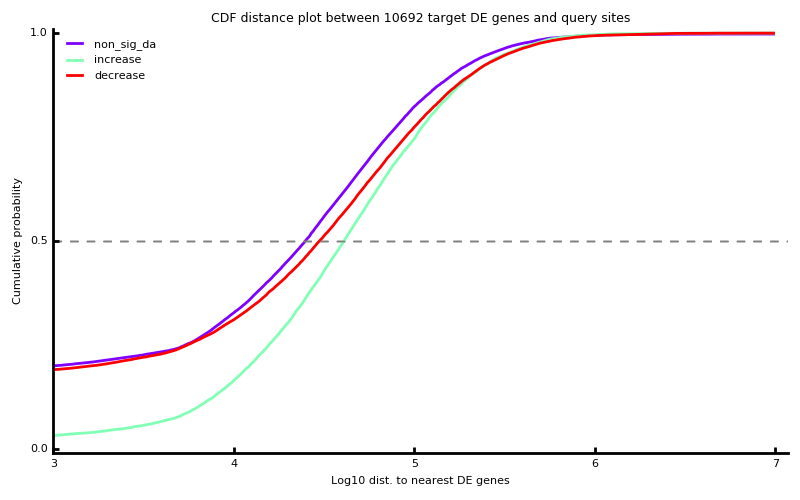

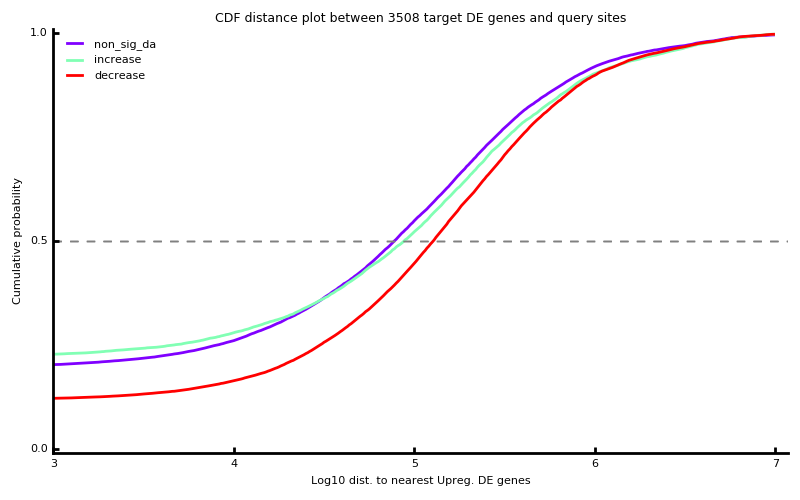

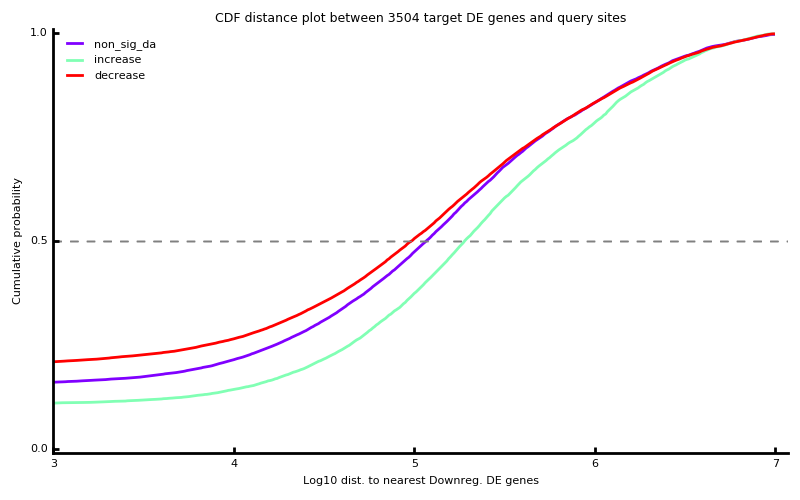

In [46]:
from IPython.display import display,Image
images = [
    "Th17_nonsigda_inc_dec",
    "Th17_nonsigda_inc_dec_upreg",
    "Th17_nonsigda_inc_dec_downreg"
    ]

for image in images:
    display(Image('/data/reddylab/Revathy/dev/atac-seq_Siklenka/results/proximity_analysis/%s.png'% image))
